# 动态学习率

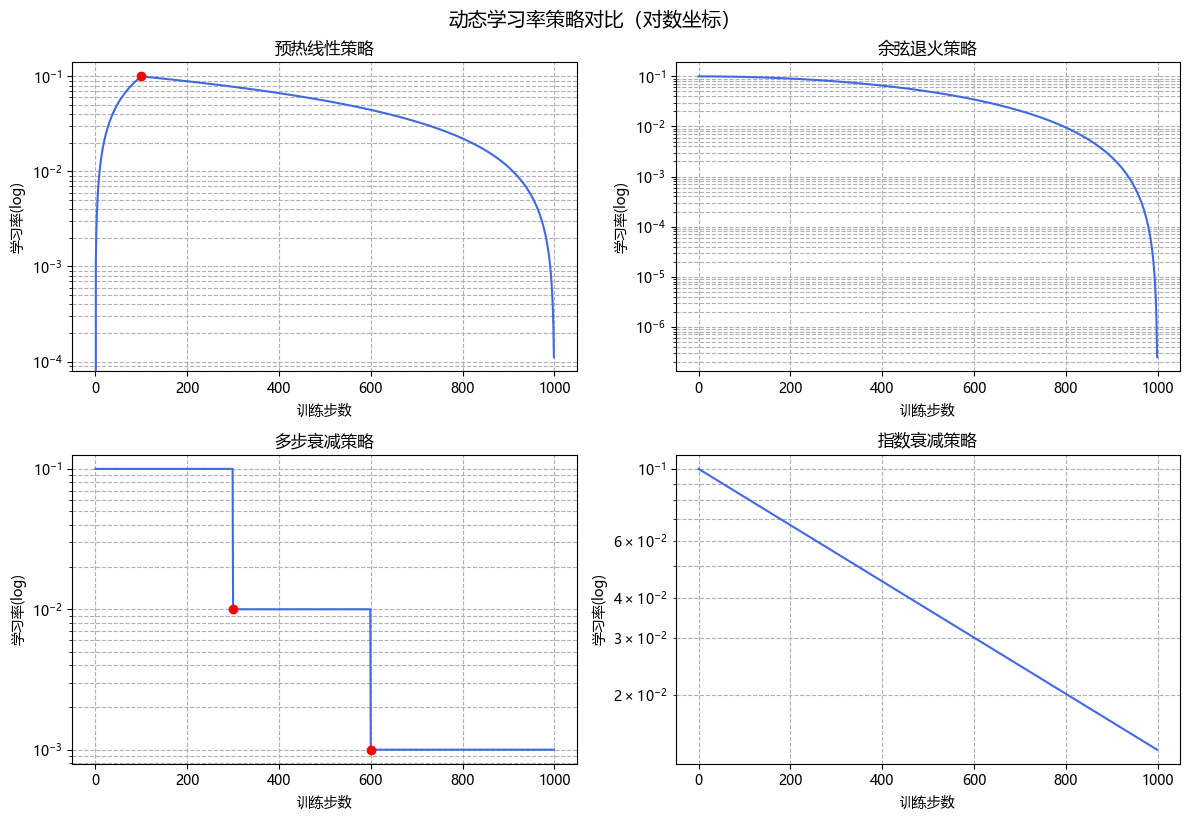

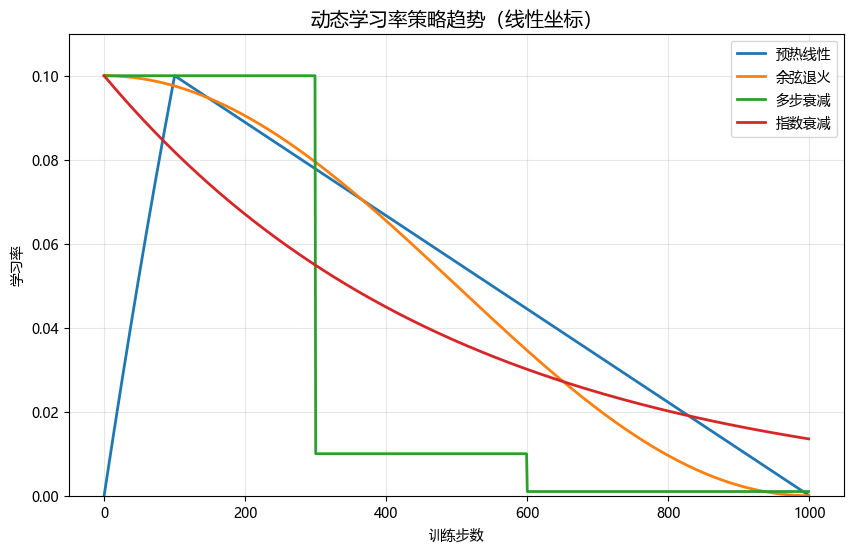

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import (
    LambdaLR, 
    CosineAnnealingLR,
    MultiStepLR,
    ExponentialLR
)

# 创建虚拟优化器（每个策略独立）
def create_scheduler(name, base_lr=0.1, total_steps=1000):
    optimizer = SGD([torch.randn(2,2)], lr=base_lr)
    
    if name == "预热线性":
        scheduler = LambdaLR(optimizer, lambda s: min(s/100, 1.0)*(1000-s)/900)
    elif name == "余弦退火":
        scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)
    elif name == "多步衰减":
        scheduler = MultiStepLR(optimizer, milestones=[300,600], gamma=0.1)
    elif name == "指数衰减":
        scheduler = ExponentialLR(optimizer, gamma=0.998)
    
    return optimizer, scheduler

# 绘制比较（使用对数坐标）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.figure(figsize=(12, 8))
strategies = ["预热线性", "余弦退火", "多步衰减", "指数衰减"]

for i, name in enumerate(strategies, 1):
    optimizer, scheduler = create_scheduler(name)
    lrs = []
    
    for step in range(1000):
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
    
    # 创建子图
    plt.subplot(2, 2, i)
    plt.plot(lrs, color='royalblue')
    plt.yscale('log')  # 对数坐标
    plt.title(f"{name}策略", fontsize=12)
    plt.xlabel("训练步数")
    plt.ylabel("学习率(log)")
    plt.grid(True, which="both", ls="--")
    
    # 添加关键点标记
    if name == "多步衰减":
        plt.scatter([300, 600], [lrs[300], lrs[600]], color='red', zorder=5)
    elif name == "预热线性":
        plt.scatter([100], [lrs[100]], color='red', zorder=5)

plt.tight_layout()
plt.suptitle("动态学习率策略对比（对数坐标）", fontsize=14, y=1.02)
plt.show()

# 添加线性坐标的全局图（仅展示趋势）
plt.figure(figsize=(10, 6))
for name in strategies:
    optimizer, scheduler = create_scheduler(name)
    lrs = []
    
    for step in range(1000):
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
    
    plt.plot(lrs, label=name, linewidth=2)

plt.title("动态学习率策略趋势（线性坐标）", fontsize=14)
plt.xlabel("训练步数")
plt.ylabel("学习率")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.11)  # 限制Y轴范围使曲线可见
plt.show()


# 模型构建和训练

## 基础模型

In [3]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import Dataset, DataLoader

# 简单数据集
class NERDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        word_ids = encoding.word_ids()
        
        # 对齐标签
        labels_encoded = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:  # 特殊token
                labels_encoded.append(-100)
            elif word_idx != prev_word_idx:  # 新词
                labels_encoded.append(label[word_idx])
            else:  # 同一个词的分片
                labels_encoded.append(-100)
            prev_word_idx = word_idx
            
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels_encoded)
        }

# 示例数据
texts = ["Apple is a company", "Microsoft was founded by Bill Gates"]
labels = [[1, 0, 0, 0], [1, 0, 0, 0, 2, 2]]  # 1=ORG, 2=PER, 0=非实体

# 创建数据集和数据加载器
dataset = NERDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=2)

# 初始化模型
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    model.train()
    for batch in dataloader:
        # 将数据移至设备
        inputs = {k: v.to(device) for k, v in batch.items()}
        
        # 前向传播
        outputs = model(**inputs)
        loss = outputs.loss
        
        # 反向传播
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.316476821899414
Epoch 2, Loss: 0.8865854144096375
Epoch 3, Loss: 0.6570150256156921


### 添加动态学习率

In [5]:
# 在步骤1的基础上添加
from torch.optim.lr_scheduler import CosineAnnealingLR

# 在优化器后添加调度器
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=len(dataloader)*3)  # T_max=总迭代次数

# 修改训练循环
for epoch in range(3):
    model.train()
    for batch in dataloader:
        # 将数据移至设备
        inputs = {k: v.to(device) for k, v in batch.items()}
        
        # 前向传播
        outputs = model(**inputs)
        loss = outputs.loss
        
        # 反向传播
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # 更新学习率
        scheduler.step()
        
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")


Epoch 1, Loss: 0.4755236506462097, LR: 3.7500000000000003e-05
Epoch 2, Loss: 0.28704288601875305, LR: 1.2500000000000007e-05
Epoch 3, Loss: 0.18292146921157837, LR: 0.0


### 添加混合精度

In [6]:
# 在步骤1的基础上添加
from torch.cuda.amp import autocast, GradScaler

# 初始化GradScaler
scaler = GradScaler()

# 修改训练循环
for epoch in range(3):
    model.train()
    for batch in dataloader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        
        # 使用混合精度
        with autocast():
            outputs = model(**inputs)
            loss = outputs.loss
        
        # 缩放梯度并更新
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


C:\Users\czx\AppData\Local\Temp\ipykernel_1404\3514583340.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
e:\miniconda\envs\nlp_prj\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\czx\AppData\Local\Temp\ipykernel_1404\3514583340.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
e:\miniconda\envs\nlp_prj\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Loss: 0.1396181732416153
Epoch 2, Loss: 0.13755744695663452
Epoch 3, Loss: 0.11692847311496735


### 分布式训练

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification

import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

# 初始化DDP
def setup(rank, world_size):
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)

def cleanup():
    dist.destroy_process_group()

# 主训练函数
def train(rank, world_size):
    try:
        setup(rank, world_size)
        
        # 数据集和数据加载器 (使用分布式采样器)
        dataset = NERDataset(texts, labels)
        sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank)
        dataloader = DataLoader(dataset, batch_size=2, sampler=sampler)
        
        # 模型 (使用DDP包装)
        model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3)
        model = model.to(rank)
        model = DDP(model, device_ids=[rank])
        
        # 训练循环 (与步骤1相同)
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
        
        for epoch in range(3):
            sampler.set_epoch(epoch)  # 确保每个epoch不同shuffle
            model.train()
            for batch in dataloader:
                inputs = {k: v.to(rank) for k, v in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            # 只在主进程打印
            if rank == 0:
                print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    
    # 保存模型 (只在主进程)
        torch.save(model.module.state_dict(), 'ner_model.pt')
    # 训练代码
    except Exception as e:
        print(f"训练出错: {e}")
        if rank == 0:
            print("尝试保存模型...")
            torch.save(model.module.state_dict(), 'ner_model.pt')
        raise

    
    cleanup()

# 启动DDP训练
world_size = torch.cuda.device_count()
torch.multiprocessing.spawn(train, args=(world_size,), nprocs=world_size)


### 模型加载和推理

In [8]:
# inference.py
from transformers import BertTokenizerFast, BertForTokenClassification
import torch

# 加载模型
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load('ner_model.pt'))
model.eval()

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def predict(text):
    encoding = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    with torch.no_grad():
        outputs = model(**encoding)
        predictions = torch.argmax(outputs.logits, dim=-1)[0]
    
    # 解码结果
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    tags = predictions.tolist()
    
    # 标签映射
    tag_names = {0: 'O', 1: 'ORG', 2: 'PER'}
    
    # 打印结果
    for token, tag in zip(tokens, tags):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            print(f"{token}: {tag_names[tag]}")
            
# 示例
predict("Tim Cook works at Apple")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: 'ner_model.pt'